In [105]:
import control as ctl
import matplotlib.pyplot as plt
import numpy as np
import sympy as sp
from scipy.optimize import fsolve
import pandas as pd
from tbcontrol.symbolic import routh

In [106]:
def sympyFunction(tf):
    num, den = ctl.tfdata(tf)
    s = sp.var('s')
    num_expr = sum(coef*s**i for i, coef in enumerate(num[0][0][::-1]))
    den_expr = sum(coef*s**i for i, coef in enumerate(den[0][0][::-1]))
    sympy_system = num_expr/den_expr
    return sympy_system

def roundSympyFunction(expr, num_digits=6):
    return expr.xreplace({n: round(n, num_digits) for n in expr.atoms(sp.Float)})

# INFORMAÇÕES DO SISTEMA
- Declarando a função de transferência e obtendo os parâmetros

In [107]:
s = ctl.TransferFunction.s
G = 1/(1.59154943091895*s + 1.0)

G_bkp = G
G

TransferFunction(array([1]), array([1.59154943, 1.        ]))

polos:  (-0.628+0j)
zeros: 


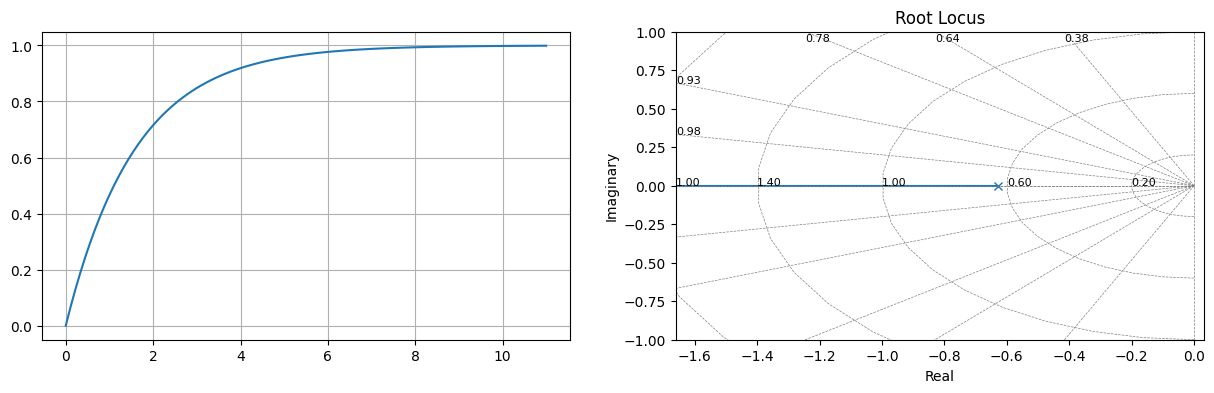

In [108]:
poles = ctl.poles(G)
zeros = ctl.zeros(G)
print('polos: ', *[np.round(pole, 3) for pole in poles])
print('zeros: ', *[np.round(zero, 3) for zero in zeros])

time, response = ctl.step_response(G)
plt.figure(figsize=(15, 4))

plt.subplot(1, 2, 1)
plt.plot(time, response)
plt.grid()

plt.subplot(1, 2, 2)
ctl.root_locus(G)

plt.show()

# INFORMAÇÕES DA RESPOSTA

In [109]:
def getOvershoot(time, response):
    peak_value = np.max(response)
    steady_state_value = response[-1]
    overshoot = (peak_value - steady_state_value) / steady_state_value
    return 'inf' if overshoot < 0 or overshoot > 999 else overshoot

def getZeta(overshoot):
    return -np.log(overshoot) / np.sqrt((np.pi**2 + np.log(overshoot)**2))

def getPeakTime(time, response):
    return time[response == max(response)][0] #time[np.argmax(response)]

def getError(response, setpoint=1):
    return abs(setpoint - abs(response[-1]))

def getSettlingTime(time, response, tolerance=0.02):
    steady_state_value = np.mean(response[-50:])
    settling_time = None
    
    if abs(steady_state_value) < 1e-6:
        lower_bound = -tolerance
        upper_bound = tolerance
    else:
        upper_bound = steady_state_value * (1 + tolerance)
        lower_bound = steady_state_value * (1 - tolerance)
    
    for i in range(len(time)):
        if lower_bound <= response[i] <= upper_bound:
            if settling_time is None:
                settling_time = time[i]
        else:
            settling_time = None
    
    return settling_time

def getAllInfo(time, response, show=True, setpoint=1):
    info = {
        'overshoot': getOvershoot(time, response),
        'peakValue': max(response),
        'peakTime': getPeakTime(time, response),
        'settlingTime': getSettlingTime(time, response),
        'finalValue': response[-1],
        'error': getError(response, setpoint)
    }

    if not show:
        return info

    print('overshoot: ', info['overshoot'])
    print('valor de pico: ', info['peakValue'])
    print('tempo de pico: ', info['peakTime'])
    print('tempo de assentamento: ', info['settlingTime'])
    print('valor final: ', info['finalValue'])
    print('erro: ', info['error'])


getAllInfo(time, response, show=False)

{'overshoot': 0.0,
 'peakValue': 0.9990000000000006,
 'peakTime': 10.994033983191393,
 'settlingTime': 5.663593264068293,
 'finalValue': 0.9990000000000006,
 'error': 0.0009999999999994458}

# REQUISITOS DO SISTEMA

(0.6901067305598217, 5.796204880881481, -4.0 + 4.195*I)

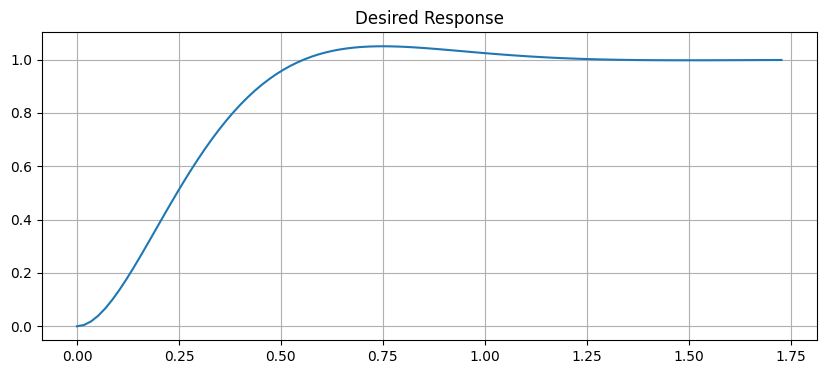

In [110]:
Ts = 1.0
UP = 0.05

zeta = -np.log(UP)/np.sqrt(np.pi**2 + np.log(UP)**2)
Wn = 4/(zeta*Ts)

s_d = -zeta*Wn + Wn*np.sqrt(1-zeta**2)*sp.I
s_d = roundSympyFunction(s_d, 3)
G_desired = Wn**2/(s**2 + 2*zeta*Wn*s + Wn**2)

time, response = ctl.step_response(G_desired)
plt.figure(figsize=(10, 4))
plt.plot(time, response)
plt.title('Desired Response'), plt.grid()
(zeta, Wn, s_d)

# CONTROLADOR
- Encontrando as constantes do controlador: $C(s) = K_p \, \big(1 + \frac{1}{T_is}\big)\big(\frac{T_ds + 1}{0.1T_ds + 1}\big)$

In [111]:
s = ctl.TransferFunction.s

In [112]:
def getResponsePID(Kp, Ti, Td):
    C = Kp * (1 + 1/(Ti*s)) * (Td*s + 1) / (0.1*Td*s + 1)
    G_feedback = ctl.feedback(G*C, 1)

    time, response = ctl.step_response(G_feedback)
    data = getAllInfo(time, response, show=False)

    if data.get('settlingTime') is None:
        return None
    
    data['Kp'] = Kp
    data['Ti'] = Ti
    data['Td'] = Td
    return data

getResponsePID(1, 1, 1)

{'overshoot': 0.0006679097188690217,
 'peakValue': 1.0012133612457812,
 'peakTime': 8.986081778192395,
 'settlingTime': 4.914263472448965,
 'finalValue': 1.0005450874577015,
 'error': 0.000545087457701543,
 'Kp': 1,
 'Ti': 1,
 'Td': 1}

In [113]:
Kp_data = np.linspace(0.01, 100, 10)
Ti_data = np.linspace(0.01, 5, 10)
Td_data = np.linspace(0.01, 5, 10)

In [114]:
data = []

for Kp in Kp_data:
    for Ti in Ti_data:
        for Td in Td_data:
            response = getResponsePID(Kp, Ti, Td)

            if response is None:
                continue
            
            data.append(response)

In [115]:
def displayLimits(df):
    display(df.head())
    print('settlingTime: ', (df.settlingTime.min().round(3), df.settlingTime.max().round(3)))
    print('overshoot:    ', (df.overshoot.min().round(3), df.overshoot.max().round(3)))
    print('error:        ', (df.error.min().round(3), df.error.max().round(3)))


df = pd.DataFrame(data)
displayLimits(df)

,overshoot,peakValue,peakTime,settlingTime,finalValue,error,Kp,Ti,Td
0,0.248658,1.249872,4.312383,10.623398,1.000973,0.000973,0.01,0.01,0.010000
1,0.103862,1.104823,4.269702,6.852120,1.000871,0.000871,0.01,0.01,0.564444
2,0.029791,1.029696,4.444740,5.764794,0.999908,0.000092,0.01,0.01,1.118889
3,0.000000,0.992882,4.899356,3.109771,0.992882,0.007118,0.01,0.01,1.673333
4,0.000000,0.999823,17.814622,5.592292,0.999823,0.000177,0.01,0.01,2.227778


settlingTime:  (0.006, 1807.359)
overshoot:     (0.0, 0.466)
error:         (0.0, 0.106)


### ANÁLISE DOS DADOS

In [116]:
df = df.loc[(df.settlingTime > 0.8*Ts) & (df.settlingTime < 1.2*Ts)]
displayLimits(df)

,overshoot,peakValue,peakTime,settlingTime,finalValue,error,Kp,Ti,Td
121,0.003225,1.003448,2.817860,1.170224,1.000222,0.000222,11.12,1.118889,0.564444
210,0.046917,1.047051,0.412615,0.943522,1.000128,0.000128,22.23,0.564444,0.010000
221,0.001271,1.001925,2.599775,0.826912,1.000653,0.000653,22.23,1.118889,0.564444
222,0.000158,1.000215,5.026212,0.866533,1.000057,0.000057,22.23,1.118889,1.118889
231,0.000000,0.999625,4.335243,1.067409,0.999625,0.000375,22.23,1.673333,0.564444


settlingTime:  (0.827, 1.17)
overshoot:     (0.0, 0.047)
error:         (0.0, 0.001)


In [117]:
df = df.loc[(df.overshoot > 0.8*UP) & (df.overshoot < 1.2*UP)]
displayLimits(df)

,overshoot,peakValue,peakTime,settlingTime,finalValue,error,Kp,Ti,Td
210,0.046917,1.047051,0.412615,0.943522,1.000128,0.000128,22.23,0.564444,0.01


settlingTime:  (0.944, 0.944)
overshoot:     (0.047, 0.047)
error:         (0.0, 0.0)


In [118]:
df = df.loc[df.error == df.error.min()]
displayLimits(df)

,overshoot,peakValue,peakTime,settlingTime,finalValue,error,Kp,Ti,Td
210,0.046917,1.047051,0.412615,0.943522,1.000128,0.000128,22.23,0.564444,0.01


settlingTime:  (0.944, 0.944)
overshoot:     (0.047, 0.047)
error:         (0.0, 0.0)


In [119]:
row = df.iloc[0].to_dict()
Kp, Ti, Td = row['Kp'], row['Ti'], row['Td']
Kp, Ti, Td

(22.23, 0.5644444444444445, 0.01)

# RESPOSTA CONTROLADA

In [120]:
s  = ctl.TransferFunction.s

C = Kp * (1 + 1/(Ti*s)) * (Td*s + 1) / (0.1*Td*s + 1)
C

TransferFunction(array([ 0.125476, 12.7699  , 22.23    ]), array([0.00056444, 0.56444444, 0.        ]))

In [121]:
G = G_bkp

G_ma = G*C
G_ma

TransferFunction(array([ 0.125476, 12.7699  , 22.23    ]), array([8.98341234e-04, 8.98905679e-01, 5.64444444e-01, 0.00000000e+00]))

In [122]:
G_feedback = ctl.feedback(G_ma, 1)
G_feedback

TransferFunction(array([ 0.125476, 12.7699  , 22.23    ]), array([8.98341234e-04, 1.02438168e+00, 1.33343444e+01, 2.22300000e+01]))

- Como todos os polos do sistema em malha fechada estão no semiplano esquerdo, o sistema é estável

polos:  (-1127.154+0j) (-11.187+0j) (-1.962+0j)
zeros:  (-100+0j) (-1.772+0j)


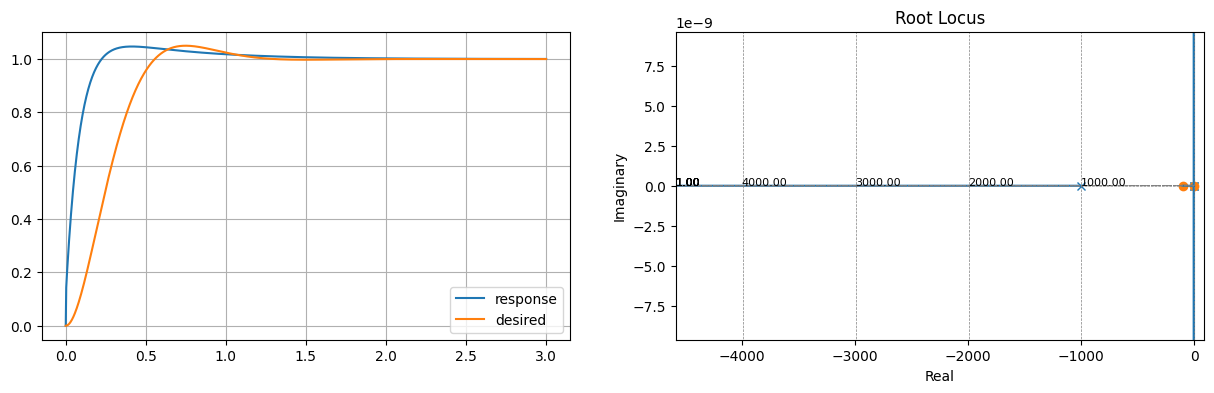

In [123]:
poles = ctl.poles(G_feedback)
zeros = ctl.zeros(G_feedback)
print('polos: ', *[np.round(pole, 3) for pole in poles])
print('zeros: ', *[np.round(zero, 3) for zero in zeros])

tData = np.linspace(0, 3*Ts, 1000)
time, response = ctl.step_response(G_feedback, T=tData)
time, desired  = ctl.step_response(G_desired, T=tData)

plt.figure(figsize=(15, 4))
plt.subplot(1, 2, 1)
plt.plot(time, response, label='response')
plt.plot(time, desired, label='desired')
plt.grid()
plt.legend()

plt.subplot(1, 2, 2)
ctl.root_locus(G_ma)
plt.show()

In [124]:
getAllInfo(time, response, setpoint=1)

overshoot:  0.0466774159920459
valor de pico:  1.0470499072775696
tempo de pico:  0.4114114114114114
tempo de assentamento:  0.9369369369369369
valor final:  1.0003558797389076
erro:  0.00035587973890760516


# APLICANDO VÁRIOS STEPS

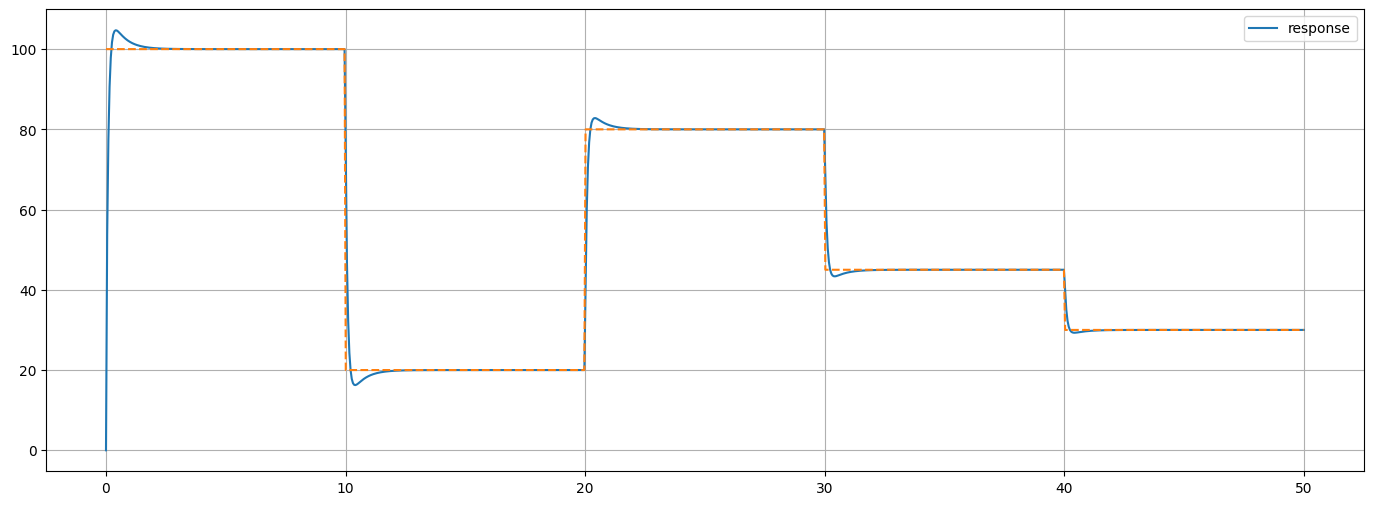

In [125]:
def makeSteps(stepList, length):
    stepSize = length // len(stepList)
    array = []

    for step in stepList:
        array = array + list(step * np.ones(stepSize))

    sizeLeft = len(array) - length

    if sizeLeft > 0:
        array = array + list(stepList[-1] * np.ones(sizeLeft))

    return array


tData = np.linspace(0, 50, 1000)
uData = makeSteps([100, 20, 80, 45, 30], len(tData))

plt.figure(figsize=(17, 6))
time, response = ctl.forced_response(G_feedback, T=tData, U=uData)
plt.plot(time, response, label='response')
plt.plot(time, uData, '--')
plt.legend()
plt.grid()